## Importing the necessary libraries

In [215]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
                      
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import metrics
from sklearn import linear_model
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import f1_score


from sklearn.model_selection import RandomizedSearchCV
import time

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

import keras
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.preprocessing import sequence

from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, Bidirectional
from keras.models import Model
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences

#make results reproducable
from numpy.random import seed
seed(1)

## Reading in the corpus

In [204]:
reviews = pd.read_csv('./train_cleaned.csv', encoding= 'unicode_escape')

In [205]:
reviews.head()

,Restaurant,Review,Label,Stars,Date,Review_clean
0,Happy Tummy,"Fresh ingredients, friendly peeps and so much ...",1,5,2016-04-06T00:00:00,fresh ingredients friendly peeps and so much c...
1,Cibo Italiano,A small selection of Italian wines by the glas...,1,4,2015-12-24T00:00:00,a small selection of italian wines by the glas...
2,Yan kee Noodle House,The plus point is that the price remains the s...,1,4,2018-12-28T00:00:00,the plus point is that the price remains the s...
3,Clinton Street Baking Company & Restaurant,Same for more?I ordered what I thought was the...,1,2,2018-03-03T00:00:00,same for more i ordered what i thought was the...
4,Brawn & Brains Coffee,I don't get why it can't just be full service....,1,3,2019-12-17T00:00:00,i don t get why it can t just be full service ...


In [206]:
reviews.Label.value_counts()

2    1117
3     699
5     693
1     520
4     434
Name: Label, dtype: int64

In [207]:
reviews.Review_clean = reviews.Review_clean.apply(lambda x: np.str_(x))

In [208]:
x = reviews.Review_clean
y = reviews.Label

In [209]:
# split x and y into training and testing sets
# stratify returns training and test subsets that have the same proportions of class labels as the input dataset.
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=1, stratify = y)

In [198]:
# examine the object shapes
print(y_train.value_counts())
print(y_test.value_counts())

2    838
3    524
5    520
1    390
4    325
Name: Label, dtype: int64
2    279
3    175
5    173
1    130
4    109
Name: Label, dtype: int64


In [199]:
## Building the vocabulary

In [25]:
vect = CountVectorizer()

In [26]:
vect.fit(x_train)
x_train_dtm = vect.transform(x_train)

# only transform x_test
x_test_dtm = vect.transform(x_test)

In [27]:
# examine the shapes: rows are documents, columns are terms (aka "tokens" or "features")
print(x_train_dtm.shape)
print(x_test_dtm.shape)

(2597, 5135)
(866, 5135)


In [28]:
# examine the last 50 features
print(vect.get_feature_names()[-50:])

['xlbs', 'xo', 'ya', 'yahoo', 'yakitori', 'yam', 'yamazaki', 'yang', 'yankee', 'yarra', 'yay', 'year', 'years', 'yeh', 'yelling', 'yellow', 'yelp', 'yelper', 'yelpers', 'yeoh', 'yes', 'yesterday', 'yet', 'yielding', 'yo', 'yoghurt', 'yogurt', 'yolk', 'york', 'you', 'young', 'your', 'yours', 'yourself', 'yu', 'yuan', 'yucatan', 'yuen', 'yummier', 'yumminess', 'yummmm', 'yummmmmmyyyy', 'yummmy', 'yummy', 'yusheng', 'yuzu', 'zealand', 'zhajing', 'zhi', 'ziplock']


# Comparing the accuracy of different approaches

In [213]:
vects = [CountVectorizer(),TfidfVectorizer()]
vectnames = ["Count Vect","Tfidf Vect"]


clfs = [BaggingClassifier(RandomForestClassifier()), MultinomialNB(),LinearSVC(),LogisticRegression(),RandomForestClassifier(),linear_model.SGDClassifier(), GradientBoostingClassifier(), AdaBoostClassifier()]
clfnames = ["bagging random forest", "Naive Bayes","Linear SVM","Logistic Regression","Random Forest","Stochastic Gradient Descent", "Gradient Boosting", "Ada Boost"]

In [220]:
#building a pipeline

for vectname, vect, in zip(vectnames, vects):

    for clfname, clf in zip(clfnames, clfs):
        pipe = Pipeline([
            ('vect', vect),
            ('clf', clf),
        ]
        )       

        pipe.fit(x_train, y_train)
        pred = pipe.predict(x_test)
     
        
        train_acc = metrics.accuracy_score(y_train, pipe.predict(x_train))
        test_acc = metrics.accuracy_score(y_test, pred)
    
        print("{} + {} - train acc: {} test acc: {} ".format(vectname, clfname, train_acc, test_acc))
#         print("macro" , f1_score(y_test, pred, average='macro'))
#         print("micro" , f1_score(y_test, pred, average='micro'))
#         print("normal" , f1_score(y_test, pred, average = 'weighted'))
       

    

Count Vect + bagging random forest - train acc: 0.9826723142087024 test acc: 0.6824480369515011 
Count Vect + Naive Bayes - train acc: 0.9083557951482479 test acc: 0.7413394919168591 
Count Vect + Linear SVM - train acc: 0.9984597612629957 test acc: 0.7551963048498845 
Count Vect + Logistic Regression - train acc: 0.9826723142087024 test acc: 0.7655889145496536 
Count Vect + Random Forest - train acc: 0.9930689256834809 test acc: 0.663972286374134 
Count Vect + Stochastic Gradient Descent - train acc: 0.9969195225259915 test acc: 0.7482678983833718 
Count Vect + Gradient Boosting - train acc: 0.8455910666153253 test acc: 0.7424942263279446 
Count Vect + Ada Boost - train acc: 0.6372737774355025 test acc: 0.6177829099307159 
Tfidf Vect + bagging random forest - train acc: 0.9788217173661917 test acc: 0.6732101616628176 
Tfidf Vect + Naive Bayes - train acc: 0.797458606083943 test acc: 0.6327944572748267 
Tfidf Vect + Linear SVM - train acc: 0.9938390450519831 test acc: 0.775981524249422

## Hyperparameter Tuning

In [31]:
# doing randomised search for logreg

from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('lr', LogisticRegression())
])


parameters = {
    'tfidf__max_df': (0.25, 0.5, 0.75),
    'tfidf__analyzer':['char', 'word', 'char_wb'],
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'tfidf__binary': [True, False],
    'tfidf__norm': [None, 'l1', 'l2'], 
    'lr__dual': [True,False],
    'lr__max_iter': [100,200, 500],
    'lr__C' :np.logspace(0, 4, num=10)
  
    
}



random =RandomizedSearchCV(pipe, parameters, cv=5, n_jobs=2)

start_time = time.time()
random_result = random.fit(x_train, y_train)
# Summarize results
print("Best: %f using %s" % (random_result.best_score_, random_result.best_params_))
print("Execution time: " + str((time.time() - start_time)) + ' ms')

pred = random.predict(x_test)
test_acc = metrics.accuracy_score(y_test, pred)
#roc_auc = metrics.roc_auc_score(y_test, pred)
pre_macro = metrics.precision_score(y_test, pred, average="macro")
recall_macro = metrics.recall_score(y_test, pred, average="macro")
f1_macro = metrics.f1_score(y_test, pred, average="macro")


print("test acc: {} recall: {} f1: {}".format(test_acc, recall_macro, f1_macro))


Best: 0.732769 using {'tfidf__norm': 'l2', 'tfidf__ngram_range': (1, 3), 'tfidf__max_df': 0.75, 'tfidf__binary': False, 'tfidf__analyzer': 'char', 'lr__max_iter': 500, 'lr__dual': False, 'lr__C': 7.742636826811269}
Execution time: 11.029325246810913 ms
test acc: 0.7655889145496536 recall: 0.7417188226645484 f1: 0.7537201414640352


In [32]:
vect = TfidfVectorizer(ngram_range=(1, 2), max_df=0.75, norm= 'l2', binary = True, analyzer = 'word')
x_train_dtm = vect.fit_transform(x_train)
x_test_dtm = vect.transform(x_test)


lr = LogisticRegression(max_iter = 100, dual = False, C = 10000)
lr.fit(x_train_dtm, y_train)
y_pred_class = lr.predict(x_test_dtm)

# Get the training accuracy
print('Training Accuracy: ', metrics.accuracy_score(y_train, lr.predict(x_train_dtm)))
# print the accuracy of its predictions
print('Test Accuracy: ', metrics.accuracy_score(y_test, y_pred_class))


Training Accuracy:  1.0
Test Accuracy:  0.7702078521939953


In [33]:
import numpy as np
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC



vect = TfidfVectorizer(ngram_range=(1, 2), max_df=0.75, norm= 'l2', binary = True, analyzer = 'word')
x_train_dtm = vect.fit_transform(x_train)
x_test_dtm = vect.transform(x_test)


lr = OneVsRestClassifier(SVC())
lr.fit(x_train_dtm, y_train)
y_pred_class = lr.predict(x_test_dtm)

# Get the training accuracy
print('Training Accuracy: ', metrics.accuracy_score(y_train, lr.predict(x_train_dtm)))
# print the accuracy of its predictions
print('Test Accuracy: ', metrics.accuracy_score(y_test, y_pred_class))

Training Accuracy:  0.9626492106276473
Test Accuracy:  0.733256351039261


In [34]:
# doing randomised search for stochastic gradient descent 

from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('sgd', linear_model.SGDClassifier())
])


parameters = {
    'tfidf__max_df': (0.25, 0.5, 0.75),
    'tfidf__analyzer':['char', 'word', 'char_wb'],
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'tfidf__binary': [True, False],
    'tfidf__norm': [None, 'l1', 'l2'], 
    
    'sgd__alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3], # learning rate
    'sgd__max_iter': [5, 100, 500, 1000], # number of epochs
    'sgd__loss': ['hinge'],
    'sgd__penalty': ['l2', 'l1', 'elasticnet'], 
    

  
    
}



random =RandomizedSearchCV(pipe, parameters, cv=5, n_jobs=2)

start_time = time.time()
random_result = random.fit(x_train, y_train)
# Summarize results
print("Best: %f using %s" % (random_result.best_score_, random_result.best_params_))
print("Execution time: " + str((time.time() - start_time)) + ' ms')

pred = random.predict(x_test)
test_acc = metrics.accuracy_score(y_test, pred)
#roc_auc = metrics.roc_auc_score(y_test, pred)
pre_macro = metrics.precision_score(y_test, pred, average="macro")
recall_macro = metrics.recall_score(y_test, pred, average="macro")
f1_macro = metrics.f1_score(y_test, pred, average="macro")


print("test acc: {} recall: {} f1: {}".format(test_acc, recall_macro, f1_macro))

Best: 0.670004 using {'tfidf__norm': None, 'tfidf__ngram_range': (1, 3), 'tfidf__max_df': 0.75, 'tfidf__binary': True, 'tfidf__analyzer': 'word', 'sgd__penalty': 'l1', 'sgd__max_iter': 100, 'sgd__loss': 'hinge', 'sgd__alpha': 0.0001}
Execution time: 5.458580017089844 ms
test acc: 0.7066974595842956 recall: 0.687761237373754 f1: 0.6835284102376928


In [35]:
vect = TfidfVectorizer(ngram_range=(1, 3), max_df=0.25, norm= 'l2', binary = False, analyzer = 'word')
x_train_dtm = vect.fit_transform(x_train)
x_test_dtm = vect.transform(x_test)


sgd = linear_model.SGDClassifier(penalty = 'l1', max_iter = 1000, loss = 'hinge', alpha = 0.0001, random_state = 1)
sgd.fit(x_train_dtm, y_train)
y_pred_class = sgd.predict(x_test_dtm)


# Get the training accuracy
print('Training Accuracy: ', metrics.accuracy_score(y_train, sgd.predict(x_train_dtm)))
# print the accuracy of its predictions
print('Test Accuracy: ', metrics.accuracy_score(y_test, y_pred_class))


Training Accuracy:  0.9168271082017713
Test Accuracy:  0.7863741339491916


In [36]:
# doing randomised search for linear svc

from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('svc', LinearSVC())
])


parameters = {
    'tfidf__max_df': (0.25, 0.5, 0.75),
    'tfidf__analyzer':['char', 'word', 'char_wb'],
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'tfidf__binary': [True, False],
    'tfidf__norm': [None, 'l1', 'l2'], 

    'svc__max_iter': [5, 100, 500, 1000], # number of epochs
    'svc__loss': ['hinge', 'squared_hinge', 'str'],
    'svc__dual':[True, False],
    'svc__penalty': ['l2', 'l1', 'str'], 
    'svc__C' :[1e-15, 1e-8, 1e-4, 1e-2, 1e-1, 1]

  
    
}



random =RandomizedSearchCV(pipe, parameters, cv=5, n_jobs=2, error_score=np.NINF)

start_time = time.time()
random_result = random.fit(x_train, y_train)
# Summarize results
print("Best: %f using %s" % (random_result.best_score_, random_result.best_params_))
print("Execution time: " + str((time.time() - start_time)) + ' ms')

pred = random.predict(x_test)
test_acc = metrics.accuracy_score(y_test, pred)
#roc_auc = metrics.roc_auc_score(y_test, pred)
pre_macro = metrics.precision_score(y_test, pred, average="macro")
recall_macro = metrics.recall_score(y_test, pred, average="macro")
f1_macro = metrics.f1_score(y_test, pred, average="macro")


print("test acc: {} recall: {} f1: {}".format(test_acc, recall_macro, f1_macro))

Best: 0.322680 using {'tfidf__norm': 'l1', 'tfidf__ngram_range': (1, 1), 'tfidf__max_df': 0.75, 'tfidf__binary': True, 'tfidf__analyzer': 'char', 'svc__penalty': 'l2', 'svc__max_iter': 5, 'svc__loss': 'squared_hinge', 'svc__dual': False, 'svc__C': 1e-08}
Execution time: 2.9926629066467285 ms
test acc: 0.32217090069284066 recall: 0.2 f1: 0.09746724890829694


/Users/charlotte/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:764: RuntimeWarning: invalid value encountered in subtract
  array_means[:, np.newaxis]) ** 2,
/Users/charlotte/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/charlotte/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [97]:
#RNN


# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
#tokenizer.fit_on_texts(reviews.Review_clean.values)

tokenizer.fit_on_texts(reviews.Review_clean.values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 5943 unique tokens.


In [98]:

# Truncate and pad the input sequences so that they are all in the same length for modeling

X = tokenizer.texts_to_sequences(reviews.Review_clean.values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (3463, 250)


In [99]:
Y = pd.get_dummies(reviews.Label).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (3463, 5)


In [100]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.30, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(2424, 250) (2424, 5)
(1039, 250) (1039, 5)


In [101]:


model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(Dropout(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(5, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 250, 100)          5000000   
_________________________________________________________________
dropout_3 (Dropout)          (None, 250, 100)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 505       
Total params: 5,080,905
Trainable params: 5,080,905
Non-trainable params: 0
_________________________________________________________________


In [102]:
epochs = 20
batch_size = 64


history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,
                    validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

/Users/charlotte/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 2181 samples, validate on 243 samples
Epoch 1/20
2181/2181 [==============================] - 11s 5ms/step - loss: 1.5625 - accuracy: 0.3081 - val_loss: 1.5013 - val_accuracy: 0.3457
Epoch 2/20
2181/2181 [==============================] - 11s 5ms/step - loss: 1.4419 - accuracy: 0.3961 - val_loss: 1.2613 - val_accuracy: 0.5432
Epoch 3/20
2181/2181 [==============================] - 11s 5ms/step - loss: 1.0938 - accuracy: 0.6222 - val_loss: 0.9853 - val_accuracy: 0.6872
Epoch 4/20
2181/2181 [==============================] - 11s 5ms/step - loss: 0.7134 - accuracy: 0.7937 - val_loss: 0.7831 - val_accuracy: 0.7284
Epoch 5/20
2181/2181 [==============================] - 11s 5ms/step - loss: 0.4496 - accuracy: 0.8808 - val_loss: 0.7168 - val_accuracy: 0.7325
Epoch 6/20
2181/2181 [==============================] - 12s 6ms/step - loss: 0.3070 - accuracy: 0.9152 - val_loss: 0.7333 - val_accuracy: 0.7325
Epoch 7/20
2181/2181 [==============================] - 16s 7ms/step - loss: 0.2063

In [104]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))



1039/1039 [==============================] - 1s 1ms/step
Test set
  Loss: 0.935
  Accuracy: 0.727


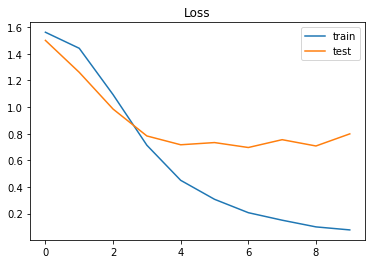

In [105]:

plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

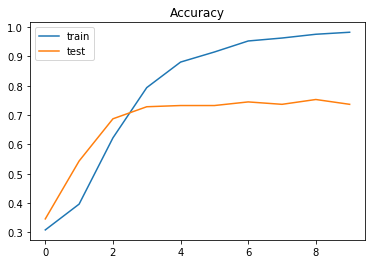

In [106]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [49]:
new_complaint = ['get full service menu decent prices pretty expensive']
seq = tokenizer.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
labels = ['Price', 'Taste', 'Service', 'Ambience', 'Others']
print(pred, labels[np.argmax(pred)])

[[9.9840444e-01 1.0729774e-05 1.3777151e-03 1.1517555e-04 9.1893584e-05]] Price


In [50]:
df = pd.DataFrame(x_test)
df.head()

,Review_clean
2865,so visiting my brother here in singapore and w...
149,be prepared to pay through your nose though bu...
3190,we went there in a weekday night
2828,highly recommend this place
3362,if you are staying in the pan pacific this foo...


In [51]:
ans = []

for i in df.Review_clean:
    new_complaint = [i]
    
    seq = tokenizer.texts_to_sequences(new_complaint)
    padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
    pred = model.predict(padded)
    labels = ['1', '2', '3', '4', '5']
    
    #print(pred, labels[np.argmax(pred)])
    #print(labels[np.argmax(pred)])
    ans.append(labels[np.argmax(pred)])
    

In [52]:
df['Predicted'] = ans
df['Actual']=y_test

In [53]:
df.head()

,Review_clean,Predicted,Actual
2865,so visiting my brother here in singapore and w...,5,5
149,be prepared to pay through your nose though bu...,1,1
3190,we went there in a weekday night,5,5
2828,highly recommend this place,5,5
3362,if you are staying in the pan pacific this foo...,5,5


In [54]:
confusion_matrix = pd.crosstab(df['Actual'], df['Predicted'], rownames=['Actual'], colnames=['Predicted'])
print (confusion_matrix)

Predicted    1    2    3   4    5
Actual                           
1          114    1    4   4    7
2            3  259    5   2   10
3            5    2  160   3    5
4            2    3    3  96    5
5            5   11    1   6  150


# Final Model used

In [55]:
unlabelled = pd.read_csv('./test_unlabelled.csv', 
                        encoding= 'unicode_escape', header = None, names = ["Name", "Comment", "Star", "Date"])

In [56]:
unlabelled.head()

,Name,Comment,Star,Date
0,Fratini La Trattoria,This is one of my absolute favorite restaurant...,5,2013-03-14T00:00:00
1,Long Beach Seafood,The dessert was good too.,4,2014-08-14T00:00:00
2,National Kitchen By Violet Oon,(I'm think that these two restaurants are rela...,4,2016-05-08T00:00:00
3,StraitsKitchen,Overall a solid 4.5 stars!,4,2018-10-27T00:00:00
4,Long Ji Zi Char,"I'm not too impressed with it as a whole but, ...",5,2016-02-18T00:00:00


In [221]:
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing

vect = TfidfVectorizer(ngram_range=(1, 3), norm= 'l2', binary = True, analyzer = 'word')
x_train_dtm = vect.fit_transform(x_train)
x_test_dtm = vect.transform(x_test)


sgd = linear_model.SGDClassifier(penalty = 'l1', max_iter = 1000, loss = 'hinge', alpha = 0.0001, random_state = 1)
sgd.fit(x_train_dtm, y_train)
y_pred_class = sgd.predict(x_test_dtm)


# Get the training accuracy
print('Training Accuracy: ', metrics.accuracy_score(y_train, sgd.predict(x_train_dtm)))
# print the accuracy of its predictions
print('Test Accuracy: ', metrics.accuracy_score(y_test, y_pred_class))

# def multiclass_roc_auc_score(y_test, y_pred_class, average="macro"):
#     lb = preprocessing.LabelBinarizer()
    
#     lb.fit(y_test)
#     y_test = lb.transform(y_test)
#     y_pred_class = lb.transform(y_pred_class)
    
#     print(y_test)
#     print('---------')
#     print(y_pred_class)
#     return roc_auc_score(y_test, y_pred_class)

# #roc_auc = metrics.roc_auc_score(y_test,5, y_pred_class,5, multi_class = 'ovr', average='macro')
# print(multiclass_roc_auc_score(y_test, y_pred_class))

Training Accuracy:  0.9145167500962649
Test Accuracy:  0.7944572748267898


In [222]:
confusion_matrix(y_test, y_pred_class)

array([[112,   7,   6,   0,   5],
       [  5, 251,   5,   5,  13],
       [  3,   9, 150,   6,   7],
       [  4,   8,   7,  82,   8],
       [  7,  51,  12,  10,  93]])

In [ ]:
# add the confusion matrix here

In [58]:
# classify all the unlabelled sentences

unlabelled['Comment'] = unlabelled['Comment'].apply(lambda x: np.str_(x))

final = vect.transform(unlabelled.Comment)

pred = sgd.predict(final)
unlabelled['Label'] = pred


In [59]:
unlabelled.head()

,Name,Comment,Star,Date,Label
0,Fratini La Trattoria,This is one of my absolute favorite restaurant...,5,2013-03-14T00:00:00,5
1,Long Beach Seafood,The dessert was good too.,4,2014-08-14T00:00:00,2
2,National Kitchen By Violet Oon,(I'm think that these two restaurants are rela...,4,2016-05-08T00:00:00,5
3,StraitsKitchen,Overall a solid 4.5 stars!,4,2018-10-27T00:00:00,5
4,Long Ji Zi Char,"I'm not too impressed with it as a whole but, ...",5,2016-02-18T00:00:00,2


In [60]:
# export to csv

unlabelled.to_csv('./final_labelled.csv')


In [61]:
unlabelled.shape

(75324, 5)